# EMG Data Exploration

In this notebook we explore the sEMG dataset for different hand gestures. We perform the following steps:

* Preprocess and clean up our dataset
* Leverage signal processing to smooth out the dataset
* Perform a variety of classification techniques

In [21]:
import random

import numpy as np
import pandas as pd

import scipy.io
import scipy
from scipy import signal

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

In [ ]:
#Workflow Pre-process -> Transform -> Classify

#Pre-processing
    #As is
    #Absolute value (all after use Absolute value)
    #Smooth (multiply hyper-parameters) 
    #Integral (add all values)
    #average
    #StD
    #RMS
    #Fit distribution?
    
#Transform
    #As is
    #PCA (multiple number of components)
    #Isomap (multiple number of components)

#Classify
    #SVM (Linear)
    #KMeans
    #GM
    #Naive-Bayes
    #DBSCAN
    #Logistic Regression
    #Neural Net

In [9]:
""" Define schema of datasets
"""

DATABASE = {
    'Database 1': ['female_1',
                  'female_2',
                  'female_3',
                  'male_1',
                  'male_2'],
    'Database 2': ['male_day_1',
                  'male_day_2',
                  'male_day_3']
}

COLUMNS = ['cyl_ch1', 
            'cyl_ch2', 
            'hook_ch1', 
            'hook_ch2', 
            'tip_ch1', 
            'tip_ch2', 
            'palm_ch1', 
            'palm_ch2', 
            'spher_ch1', 
            'spher_ch2', 
            'lat_ch1', 
            'lat_ch2']

LABELS = [
    'Spherical',
    'Tip',
    'Palmar',
    'Lateral',
    'Cylindrical',
    'Hook'
]

COL_MAPPINGS = {
            'cyl_ch1': 'Cylindrical', 
            'cyl_ch2': 'Cylindrical', 
            'hook_ch1': 'Hook', 
            'hook_ch2': 'Hook', 
            'tip_ch1': 'Tip', 
            'tip_ch2': 'Tip', 
            'palm_ch1': 'Palmar', 
            'palm_ch2': 'Palmar', 
            'spher_ch1': 'Spherical', 
            'spher_ch2': 'Spherical', 
            'lat_ch1': 'Lateral', 
            'lat_ch2': 'Lateral'
}

In [143]:
""" Preprocess and standardize dataset into a single dataframe table
"""

DB_NAME = 'Database 1'
dfs = []
for fname in DATABASE[DB_NAME]: 
    tmp_data = scipy.io.loadmat(f'./data/{DB_NAME}/{fname}')
    tmp_data = {k:v for k,v in tmp_data.items() if k in COLUMNS}
    for c in COLUMNS:
        tmp_dfx = pd.DataFrame(tmp_data[c])
        tmp_dfx['identifier'] = fname
        tmp_dfx['label'] = COL_MAPPINGS[c]
        dfs.append(pd.DataFrame(tmp_dfx))

        
dataset = pd.concat(dfs)
print("Dimensions", dataset.shape)
dataset.head()

Dimensions (1800, 3002)


,0,1,2,3,4,5,6,7,8,9,...,2992,2993,2994,2995,2996,2997,2998,2999,identifier,label
0,0.072198,0.276211,0.429221,0.327214,0.123201,0.097700,0.072198,0.021195,-0.004307,0.174205,...,0.276211,-0.259323,0.072198,1.882814,0.480224,-2.528968,0.097700,0.837247,female_1,Cylindrical
1,0.250710,0.301713,0.199706,0.378218,0.021195,-0.080812,-0.106313,0.021195,0.276211,0.072198,...,-1.304890,0.786244,0.786244,0.939254,1.270775,-0.616346,0.454723,0.021195,female_1,Cylindrical
2,0.123201,0.148703,0.148703,0.123201,-0.004307,-0.157317,-0.029808,0.174205,0.199706,0.250710,...,-0.233821,0.403719,0.046696,-0.080812,0.378218,-0.361330,0.505726,0.607732,female_1,Cylindrical
3,0.531228,-0.106313,-0.284825,-0.335828,-0.182818,0.123201,0.301713,0.352716,0.327214,-0.029808,...,0.709739,0.276211,-0.080812,0.123201,0.735241,1.270775,-0.769356,-1.687415,female_1,Cylindrical
4,-0.310326,-0.182818,0.276211,0.480224,0.352716,0.123201,0.123201,0.097700,-0.029808,-0.080812,...,-0.208320,0.429221,0.378218,0.633234,0.811746,0.403719,-0.182818,-0.412333,female_1,Cylindrical


In [197]:
#combine coupled readouts
new_dfs = []
for lab in LABELS:
    new_temp = dataset[dataset['label'] == lab].values
    new_temp_comb = pd.DataFrame(np.concatenate((new_temp[:150,:3000],new_temp[150:,:3002]),axis=1))
    new_dfs.append(new_temp_comb)
    


new_dataset = pd.concat(new_dfs)
new_dataset.rename(columns={6001:'label', 6000:'identifier'}, inplace=True)

In [199]:
new_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,5992,5993,5994,5995,5996,5997,5998,5999,identifier,label
0,0.505726,0.531228,0.505726,0.021195,0.046696,-0.080812,0.021195,0.021195,0.123201,0.199706,...,0.227693,0.049139,-0.30797,-0.103908,0.100154,0.15117,-0.614063,-0.358985,female_3,Spherical
1,0.454723,0.174205,-0.182818,-0.386831,0.709739,0.633234,-0.029808,-0.20832,0.0977,0.582231,...,-0.333478,0.100154,0.71234,0.610309,0.559294,-0.410001,0.253201,-0.052892,female_3,Spherical
2,1.24527,0.123201,-2.27395,-2.937,-0.335828,1.50029,1.39828,2.16333,0.403719,-0.131815,...,0.253201,-0.486524,-0.231447,-0.30797,0.100154,0.865386,0.635817,0.15117,female_3,Spherical
3,-0.080812,-0.182818,0.0977,0.123201,0.276211,0.352716,0.25071,0.199706,0.0977,-0.080812,...,0.227693,-0.818125,-0.052892,0.431755,0.457263,0.304216,0.125662,0.304216,female_3,Spherical
4,0.480224,0.021195,0.429221,0.021195,-0.004307,-0.106313,0.199706,0.199706,0.301713,0.276211,...,-0.103908,-1.12422,0.278708,0.94191,0.686832,0.023631,-1.12422,-0.333478,female_3,Spherical


In [11]:
dx = scipy.io.loadmat('./data/Database 2/male_day_1.mat')
dx.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cyl_ch1', 'cyl_ch2', 'hook_ch1', 'hook_ch2', 'tip_ch1', 'tip_ch2', 'palm_ch1', 'palm_ch2', 'spher_ch1', 'spher_ch2', 'lat_ch1', 'lat_ch2'])

In [68]:


#absolute value
def abs_val_filter(data):
    """ Apply an absolute value filter to a DataFrame
    """
    return abs(data.copy())


def butterworth_low_pass_filter(data, 
                                frequency=500, 
                                lp_filter=5,
                                order=4):

    lp_filter = lp_filter/(frequency/2)

    # Create a lowpass butterworth signal 
    B, A = scipy.signal.butter(order, 
                               lp_filter, 
                               btype='lowpass')

    # Apply the lowpass signal filter to EMG data
    smooth_emg = scipy.signal.filtfilt(B, 
                                       A, 
                                       data)
    return smooth_emg


def holt_smoothing(data,
                  s_level = 0.5,
                  s_slope = 0.1):
    smoothed = Holt(data[0]).fit(smoothing_level=s_level, smoothing_slope=s_slope).fittedvalues[:]
    print(data[0])
    print(smoothed)
    return smoothed
    

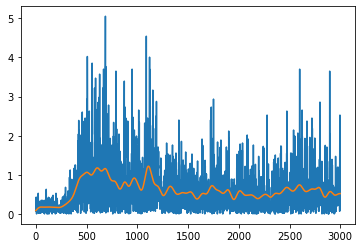

In [73]:
df_features = dataset.iloc[:,:3000].copy()
df_labels = dataset.iloc[:, 3001]

df_features = abs_val_filter(df_features)
smoothed_emg_df = butterworth_low_pass_filter(df_features.to_numpy(),
                                             frequency=5000,
                                             lp_filter=50)
plt.plot(df_features.to_numpy()[0])
plt.plot(smoothed_emg_df[0])

[0.072198 0.276211 0.429221 ... 2.528968 0.0977   0.837247]
[0.17716921 0.17194296 0.1772308  ... 0.57297383 0.67216175 0.64453965]


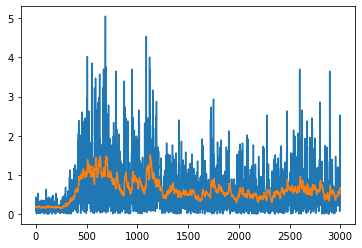

In [74]:
df_features = dataset.iloc[:,:3000].copy()
df_labels = dataset.iloc[:, 3001]

df_features = abs_val_filter(df_features)
holt_emg_df = holt_smoothing(df_features.to_numpy(), s_level = 0.05, s_slope = 0.01)

smoothed_emg_df
plt.plot(df_features.to_numpy()[0])
plt.plot(holt_emg_df)

In [130]:
#Transform
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(smoothed_emg_df.T)
transformed = pca.components_.T

In [131]:
X_train, X_test, y_train, y_test = train_test_split(transformed, 
                                                    df_labels, 
                                                    test_size=0.2, 
                                                    random_state=3)
clf = make_pipeline(StandardScaler(),
                    SVC(gamma='auto', 
                        degree=2))
clf.fit(X_train, y_train)

svm_labels = clf.predict(X_test)

(svm_labels == y_test).value_counts()/len(X_test)


False    0.65
True     0.35
Name: label, dtype: float64

In [120]:
""" Split EMG dataset into training and testing
"""

X_train, X_test, y_train, y_test = train_test_split(smoothed_emg_df, 
                                                    df_labels, 
                                                    test_size=0.2, 
                                                    random_state=3)

In [121]:
""" SVM Classification Results
"""

clf = make_pipeline(StandardScaler(),
                    SVC(gamma='auto', 
                        degree=2))
clf.fit(X_train, y_train)

svm_labels = clf.predict(X_test)

(svm_labels == y_test).value_counts()/len(X_test)

False    0.669444
True     0.330556
Name: label, dtype: float64

False    1.0
Name: label, dtype: float64